In [1]:
from src.utilities import sample_train_eval_files
from parameters.dataset_params import TRAIN_DATASET_PARAMS
from src.dataset import TrainDataset
from parameters.params import UNCUT_SPECTS_DIR_PATH, AUDIO_FILE_FMT, SPECT_FILE_FMT

In [2]:
train_files_list, eval_files_list = sample_train_eval_files(
    UNCUT_SPECTS_DIR_PATH,
    50,
    10,
    AUDIO_FILE_FMT,
    SPECT_FILE_FMT,
)

train_dataset = TrainDataset(
    **TRAIN_DATASET_PARAMS,
    audio_files_list=train_files_list
)

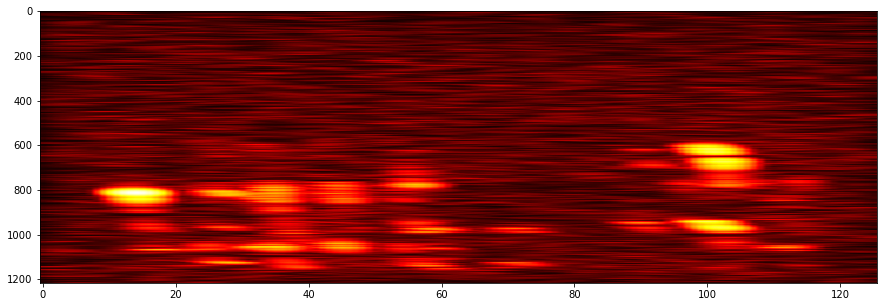

In [3]:
from matplotlib import pyplot as plt 
import numpy as np 
windows = train_dataset[20][0]
for n, w in windows.items():
    fig = plt.figure(figsize=(15,5))
    plt.imshow(np.flip(w.numpy(), 0), aspect='auto', cmap='hot')

In [1]:
from glob import glob
import torch
import numpy as np 
import pickle
from matplotlib import pyplot as plt 
from parameters.train_params import NUM_RUNS, EVAL_STEP

In [2]:
from parameters.params import WINDOW_DUR

In [3]:
from glob import glob 
result_files = glob("./results/wrapup/snr0.5/*.pkl")

In [4]:
result_files

['./results/wrapup/snr0.5/256.512.1024_1000ms.pkl',
 './results/wrapup/snr0.5/64.128.256.512.1024.2048.4096_1000ms.pkl',
 './results/wrapup/snr0.5/2048_1000ms.pkl',
 './results/wrapup/snr0.5/256_1000ms.pkl',
 './results/wrapup/snr0.5/1024_1000ms.pkl',
 './results/wrapup/snr0.5/4096_1000ms.pkl',
 './results/wrapup/snr0.5/512_1000ms.pkl',
 './results/wrapup/snr0.5/128_1000ms.pkl',
 './results/wrapup/snr0.5/64_1000ms.pkl']

In [5]:
std_d = {}
acc_d = {}
xs_d = {}
for rf in result_files:
    with open(rf, "rb") as handle:
        all_xs, acc_histories, ds = pickle.load(handle)
    all_durs = []
    for r in range(NUM_RUNS):
        xs = []
        for i in range(EVAL_STEP, max(all_xs[r]), EVAL_STEP):
            xs.append(i)
        durs = []
        for x in xs:
            durs.append(x * WINDOW_DUR)
        all_durs.append(durs)
    min_len = min(list(map(lambda x : len(x), all_durs)))
    for i, d in enumerate(all_durs):
        all_durs[i] = d[:min_len]
    for i,d in enumerate(all_durs):
        if len(acc_histories[i]) != len(d):
            acc_histories[i] = acc_histories[i][:len(d)]
    acc_d[rf] = [sum(i) / NUM_RUNS for i in zip(*acc_histories)]
    xs_d[rf] = all_durs[0]
    std_d[rf] = np.std(np.array(acc_histories).transpose(), 1)

In [6]:
titles_colors = {
    "./results/wrapup/snr0.5/64_1000ms.pkl": ("64","purple"),
    "./results/wrapup/snr0.5/128_1000ms.pkl": ("128","orange"),
    "./results/wrapup/snr0.5/256_1000ms.pkl": ("256","blue"),
    "./results/wrapup/snr0.5/512_1000ms.pkl": ("512", "green"), 
    "./results/wrapup/snr0.5/1024_1000ms.pkl": ("1024", "red"),
    "./results/wrapup/snr0.5/2048_1000ms.pkl": ("2048", "pink"),
    "./results/wrapup/snr0.5/4096_1000ms.pkl": ("4096", "black"),
    "./results/wrapup/snr0.5/256.512.1024_1000ms.pkl": ("Wideband", "brown"),
    "./results/wrapup/snr0.5/64.128.256.512.1024.2048.4096_1000ms.pkl": ("Extreme Wideband", "gray"),
}

In [9]:
acc_d.keys()

dict_keys(['./results/wrapup/snr1/256.512.1024_1000ms.pkl', './results/wrapup/snr1/2048_1000ms.pkl', './results/wrapup/snr1/256_1000ms.pkl', './results/wrapup/snr1/1024_1000ms.pkl', './results/wrapup/snr1/4096_1000ms.pkl', './results/wrapup/snr1/512_1000ms.pkl', './results/wrapup/snr1/128_1000ms.pkl', './results/wrapup/snr1/64_1000ms.pkl'])

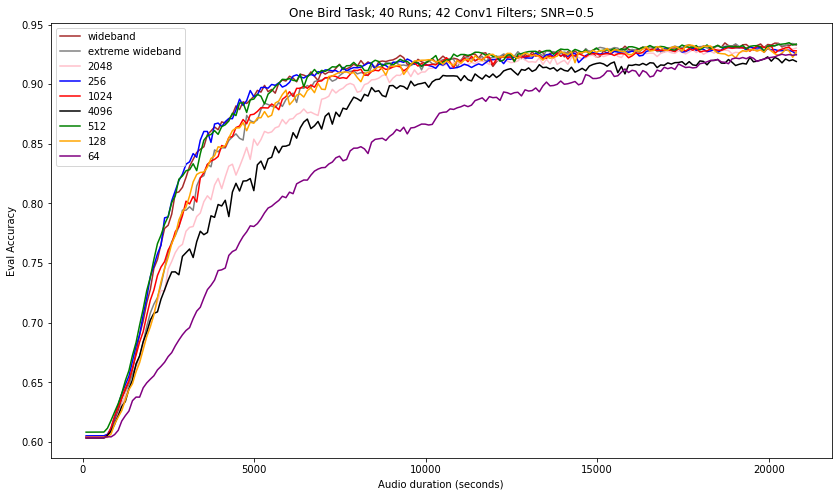

In [8]:
fig = plt.figure(figsize=(14,8))
for n, acc in acc_d.items():
    #print(n)
    plt.xlabel("Audio duration (seconds)")
    plt.ylabel("Eval Accuracy")
    plt.title("One Bird Task; 40 Runs; 42 Conv1 Filters; SNR=0.5")
    xs = xs_d[n][:200]
    plt.plot(xs, acc[:200], color=titles_colors[n][1])
plt.legend(['wideband', 'extreme wideband', '2048', '256', '1024', '4096', '512', '128', '64'])

In [7]:
import plotly.graph_objects as go
import numpy as np

In [26]:
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

names = [
    '256, 512, 1024 (wideband)',
    '64, 128, ..., 2048, 4096 (xtrm-wideband)',
    '2048',
    '256',
    '1024',
    '4096',
    '512',
    '128',
    '64',
]

In [31]:
fig = go.Figure(
    layout=go.Layout(
        title=go.layout.Title(text="TweetyNet Noisy Classification"),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text="x Axis",
            )
        ),
    )
)
for i, (n, acc) in enumerate(acc_d.items()):
    xs = xs_d[n]
    std = std_d[n]
    upper = acc + std
    lower = acc - std
    # fig.add_trace(go.Scatter(
    #     x=xs,
    #     y=lower+upper,
    #     fill='toself',
    #     fillcolor='rgba(0,100,80,0.2)',
    #     line_color='rgba(255,255,255,0)',
    #     showlegend=False,
    #     name='Fair',
    # ))
    fig.add_trace(go.Scatter(
    x=xs, y=acc,
    line_color=colors[i],
    name=names[i],
    ))

fig.update_traces(mode='lines')
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))
fig.show()


ValueError: 
    Invalid value of type 'plotly.graph_objs.layout._title.Title' received for the 'title' property of layout.xaxis
        Received value: layout.Title({
    'text': 'Number of Training Windows'
})

    The 'title' property is an instance of Title
    that may be specified as:
      - An instance of :class:`plotly.graph_objs.layout.xaxis.Title`
      - A dict of string/value properties that will be passed
        to the Title constructor

        Supported dict properties:
            
            font
                Sets this axis' title font. Note that the
                title's font used to be customized by the now
                deprecated `titlefont` attribute.
            standoff
                Sets the standoff distance (in px) between the
                axis labels and the title text The default
                value is a function of the axis tick labels,
                the title `font.size` and the axis `linewidth`.
                Note that the axis title position is always
                constrained within the margins, so the actual
                standoff distance is always less than the set
                or default value. By setting `standoff` and
                turning on `automargin`, plotly.js will push
                the margins to fit the axis title at given
                standoff distance.
            text
                Sets the title of this axis. Note that before
                the existence of `title.text`, the title's
                contents used to be defined as the `title`
                attribute itself. This behavior has been
                deprecated.


In [13]:
acc + std

array([0.61350517, 0.61350517, 0.61350517, 0.61350517, 0.61404897,
       0.61554112, 0.61522908, 0.62513696, 0.63628894, 0.64510365,
       0.65390676, 0.66074702, 0.67020294, 0.68602613, 0.70627355,
       0.72373564, 0.73688448, 0.75684142, 0.76747613, 0.78806011,
       0.79788197, 0.80951527, 0.82163178, 0.82582826, 0.84434055,
       0.84806454, 0.85058223, 0.85233411, 0.85599797, 0.86222038,
       0.8700665 , 0.87062283, 0.87917905, 0.88376421, 0.88616784,
       0.88318746, 0.88733438, 0.88858538, 0.89978995, 0.90175812,
       0.90387759, 0.90040774, 0.90238219, 0.91899687, 0.90630103,
       0.90762512, 0.91095026, 0.91231132, 0.91611194, 0.91375258,
       0.91849421, 0.92731377, 0.91618869, 0.93246027, 0.92006754,
       0.92348376, 0.92144449, 0.92081654, 0.92478032, 0.93273726,
       0.92491554, 0.92872416, 0.92567959, 0.92338108, 0.93763812,
       0.93506685, 0.92520959, 0.92956204, 0.92591556, 0.92434262,
       0.92723036, 0.92817881, 0.93366303, 0.92982857, 0.92630